# Проект: классификация

In [ ]:
#!pip install category_encoders
#!pip install optuna

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import optuna
import category_encoders as ce
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

Бизнес-задача:
1. Определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.
2. Построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

### Данные о клиентах банка:

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

### Данные, связанные с последним контактом:

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

### Прочие признаки:

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

### Целевой признак:

- deposit.

In [4]:
#ЕСЛИ РАБОТАЕМ В GOOGLE COLAB
# подключаем google диск, где у нас хранятся данные
from google.colab import drive
drive.mount('/content/drive')
path = '.../bank_fin.csv'

Mounted at /content/drive


Прочитаем данные и ознакомимся с ними.

In [5]:
df = pd.read_csv(path, sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Исследуем данные на предмет пропусков.

In [7]:
MissingValue = df.isnull().sum().sort_values(ascending = False)
Percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
MissingData = pd.concat([MissingValue, Percent], axis=1, keys=['Пропущенные значения', 'Процент'])
MissingData.head(3)

,Пропущенные значения,Процент
balance,25,0.223974
age,0,0.000000
day,0,0.000000


В некоторых признаках есть пропуски обозначенные как unknown.

In [8]:
df.job.value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

Преобразуем признак balance в вещественное число (float).

In [67]:
def edit_the_balance(balance):
  if balance!='nan':
    balance = balance.replace('$','').replace(',00','').replace(' ','')
    return balance
  else:
    return np.nan

df['balance'] = df.balance.astype(str).apply(edit_the_balance)
df['balance'] = df['balance'].astype(float)

Заменим пропуски в признаке balance на медиану.

In [68]:
df['balance'].fillna(value=df.balance.median(), inplace=True)

Заменим пропуски в категориальных признаках job и education на модальные значения.

In [69]:
df['job'] = df['job'].apply(lambda text: df.job.mode()[0] if text == 'unknown'
                                                          else text)
df['education'] = df['education'].apply(lambda text: df.education.mode()[0] if text == 'unknown'
                                                                             else text)

Удалим выбросы для признака balance. Воспользуемся методом Тьюки.

In [70]:
perc25 = df.balance.quantile(0.25)
perc75 = df.balance.quantile(0.75)
IQR = perc75 - perc25
print(f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, межквартильный размах: {IQR}')

low_bound = perc25 - 1.5*IQR
high_bound = perc75 + 1.5*IQR
print(f'Границы выбросов: [{low_bound}, {high_bound}]')

del_index = []
for i in range(0, df.shape[0]):
  if df.balance[i] <= low_bound or df.balance[i] >= high_bound:
    del_index.append(i)

df.drop(index=del_index, axis=0, inplace=True)

25-й перцентиль: 123.0, 75-й перцентиль: 1699.0, межквартильный размах: 1576.0
Границы выбросов: [-2241.0, 4063.0]


## Часть 2:  Разведывательный анализ

Изучим соотношение классов на предмет несбалансированности.

no     0.536718
yes    0.463282
Name: deposit, dtype: float64

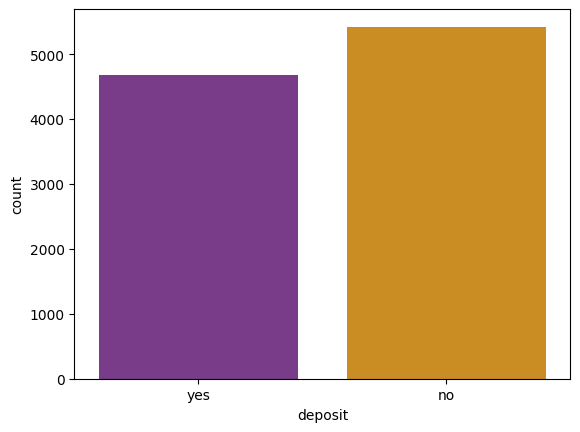

In [71]:
sns.countplot(x = df.deposit, palette='CMRmap')

df.deposit.value_counts(normalize=True)

Данные можно отнести к сбалансированным, т.к. отличаются они незначительно (на 7%). Однако стратификация выборки не помешает.

Изучим описательные статистики для количественных переменных.

In [72]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10104.000000,10104.000000,10104.000000,10104.000000,10104.000000,10104.000000,10104.000000
mean,40.895487,807.331354,15.590657,368.777712,2.516924,51.307700,0.816112
std,11.735511,993.673452,8.441852,346.650712,2.707180,109.643031,2.243875
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,444.500000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1224.750000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4062.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Изучим описательные статистики для категориальных переменных.

In [73]:
df.describe(include = 'object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10104,10104,10104,10104,10104,10104,10104,10104,10104,10104
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2314,5714,5517,9938,5243,8711,7282,2616,7570,5423


И визуализируем результаты.

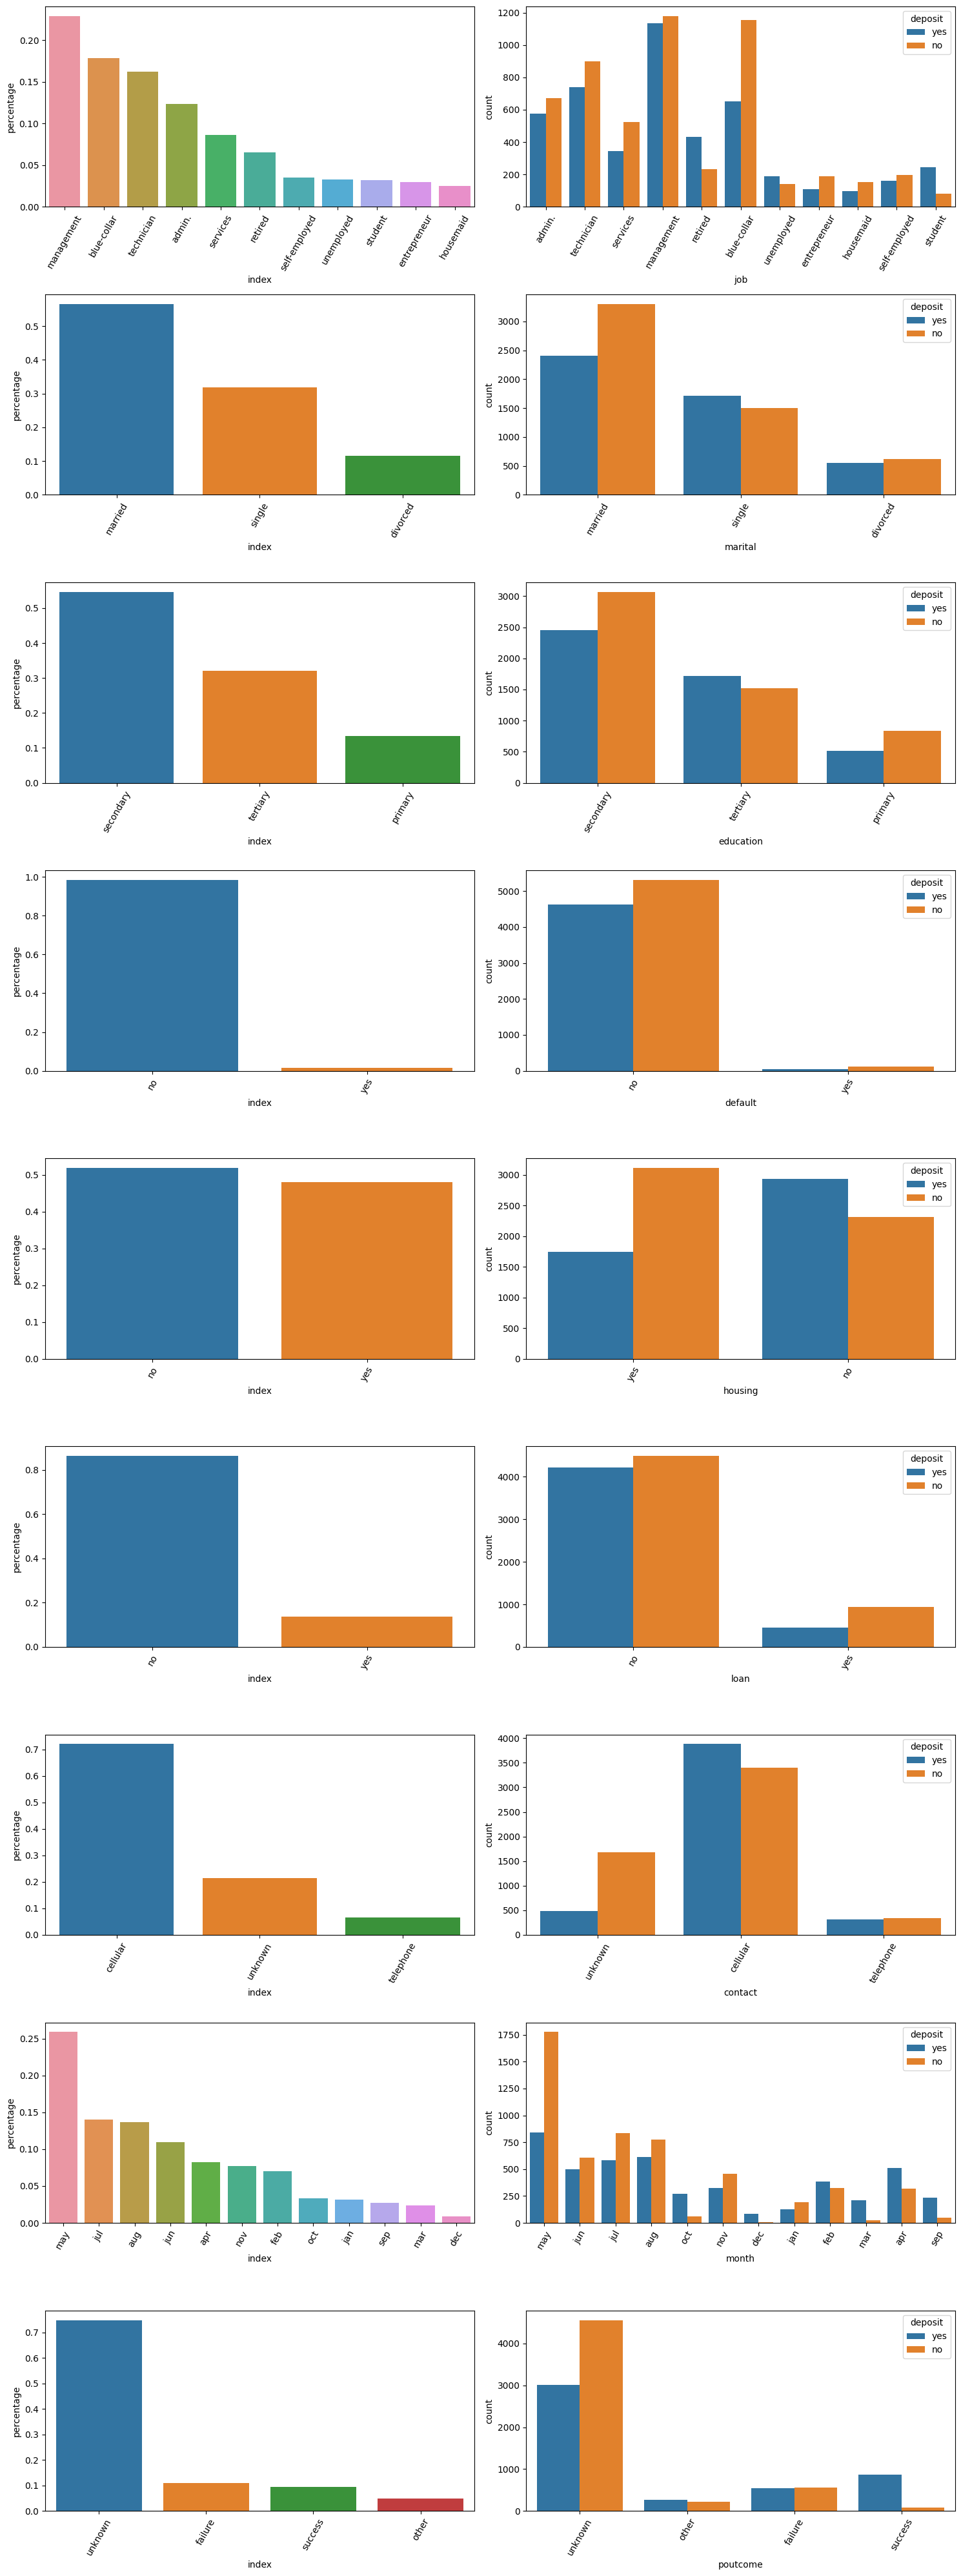

In [74]:
cat_features = ['job','marital','education','default','housing','loan','contact',	'month','poutcome']

fig, axes = plt.subplots(9, 2, figsize=(15, 40))

for i, feature in enumerate(cat_features):
    # Столбчатая диаграмма для долевого соотношения каждой из категорий в данных
    count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data,
                                x='index',
                                y='percentage',
                                ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)

    #Столбчатая диаграмма клиентов с депозитом и без в зависимости от категории
    countplot = sns.countplot(data=df,
                          x=feature,
                          hue='deposit',
                          ax=axes[i][1])
    countplot.xaxis.set_tick_params(rotation=60)

plt.tight_layout()

Выясним, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

<Axes: xlabel='poutcome'>

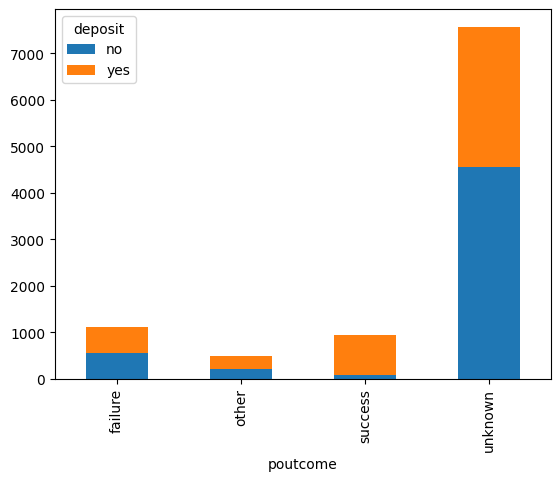

In [75]:
types = df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

По графику видно, что успех превалирует в кампании со статусом success. Статус unknown можно отнести к failure.

Выясним в каком месяце чаще всего отказывались от предложения открыть депозит.

In [76]:
df[(df.poutcome == 'failure') &
 (df.deposit == 'no')].groupby(['month'])['deposit'].count().sort_values(ascending = False)

month
may    216
nov     92
apr     84
feb     71
jan     30
aug     19
oct     18
jun     10
sep     10
jul      8
dec      2
mar      1
Name: deposit, dtype: int64

Выясним в каких возрастных группах более склонны открывать депозит. Для этого создадим новый признак age_group.

<Axes: xlabel='age_group', ylabel='count'>

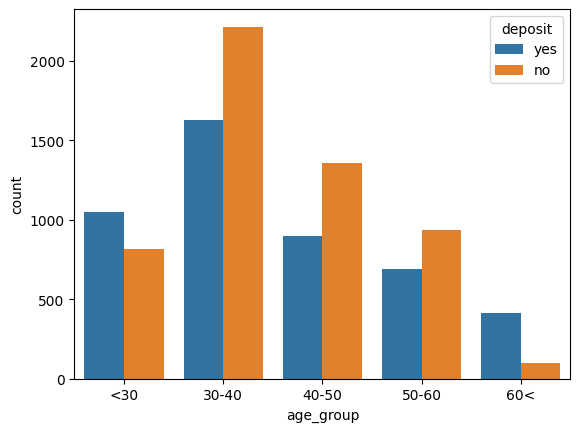

In [77]:
df['age_group'] = pd.cut(df.age, [0, 30, 40, 50, 60, 100], labels=['<30','30-40','40-50', '50-60', '60<'])
sns.countplot(data=df,
              x="age_group",
              hue="deposit")


Визуализация для открывших и неоткрывших депозит в зависимости от семейного статуса.

<Axes: xlabel='marital', ylabel='count'>

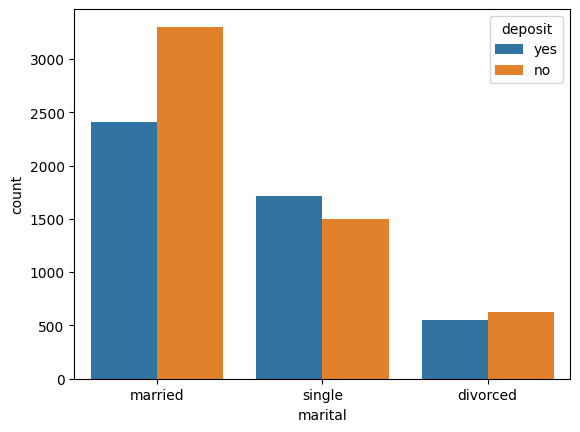

In [78]:
sns.countplot(data=df,
              x="marital",
              hue="deposit")

Визуализация для открывших и неоткрывших депозит в зависимости от образования.

<Axes: xlabel='education', ylabel='count'>

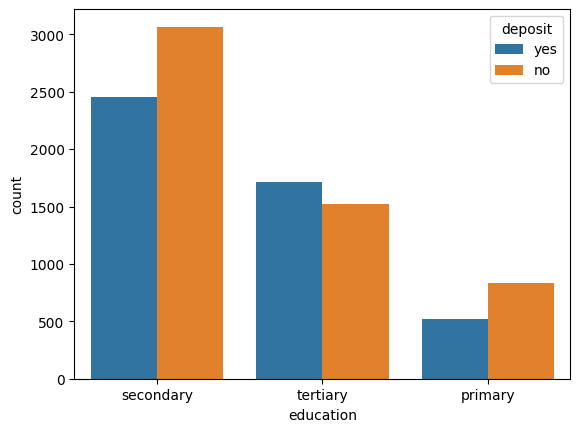

In [79]:
sns.countplot(data=df,
              x="education",
              hue="deposit")

Визуализация для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости.

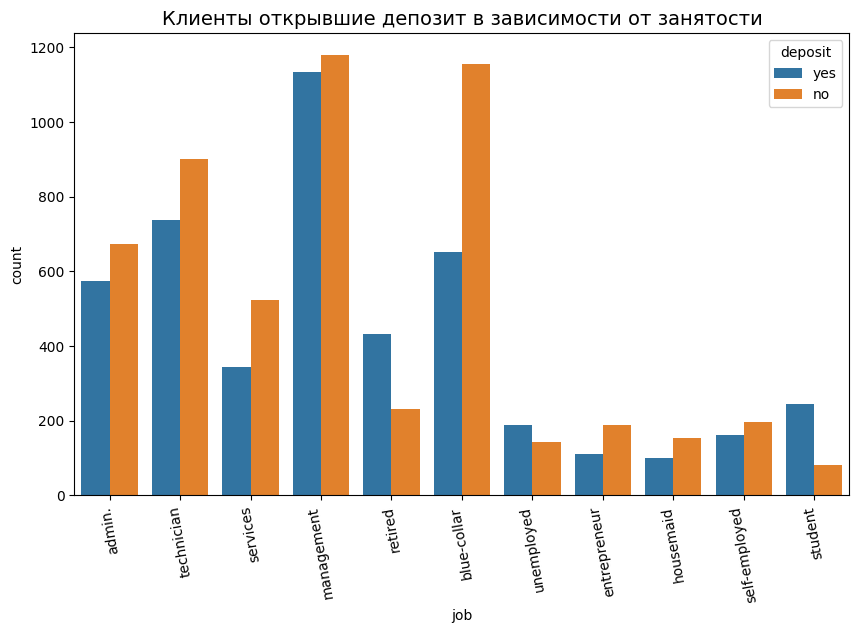

In [80]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df,
              x="job",
              hue="deposit")
ax.set_xticklabels(ax.get_xticklabels(), rotation=100)
plt.title('Клиенты открывшие депозит в зависимости от занятости', fontsize=14)
plt.show()

Определим клиенты с каким образованием и семейным статусом наиболее многочисленны.

In [81]:
pd.crosstab(df.education, df.marital)

marital,divorced,married,single
education,,,
primary,187,980,182
secondary,653,3119,1745
tertiary,337,1615,1286


## Часть 3: преобразование данных

Для работы моделей машинного обучения закодируем категориальные данные.

In [82]:
LE = preprocessing.LabelEncoder()
df['education'] = LE.fit_transform(df.education)
df['age_group'] = LE.fit_transform(df.age_group)

In [83]:
LB = preprocessing.LabelBinarizer()
df['deposit'] = LB.fit_transform(df.deposit)
df['default'] = LB.fit_transform(df.default)
df['housing'] = LB.fit_transform(df.housing)
df['loan'] = LB.fit_transform(df.loan)

In [84]:
cols=['job', 'marital', 'contact', 'month', 'poutcome']
dummies = pd.get_dummies(df[cols])
df = pd.concat([df, dummies], axis=1)
df.drop(cols, axis=1, inplace=True)

Оценим данные на предмет наличия мультиколлинеарности с целевой переменной.

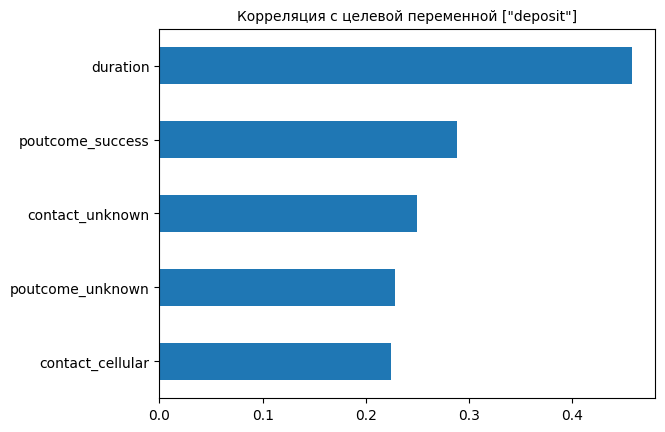

In [85]:
df.corr()['deposit'].apply(lambda x: abs(x)).sort_values()[-6:-1].plot.barh()
plt.title('Корреляция с целевой переменной ["deposit"]', fontsize = 10)
plt.show()

Высокой корреляции (более 0,7) нет.

Разделим данные на тестовую и обучающую выборки.

In [86]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

Так как признаков очень много, отберём 15 наиболее полезных признаков.

In [87]:
features = SelectKBest(f_classif, k=15).fit(X_test, y_test)
cols = list(features.get_feature_names_out())
X_train, X_test = X_train[cols], X_test[cols]
display(f'Наиболее значимые признаки: {cols}')

"Наиболее значимые признаки: ['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous', 'age_group', 'contact_cellular', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']"

Нормализуем данные с помощью MinMaxScaler.

In [88]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

Для начала обучим логистическую регрессию и рассчитаем метрики качества. Отслеживать качество будем по метрике F1.

In [91]:
log_reg = linear_model.LogisticRegression(
    solver='sag',
    random_state=42,
    max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)

y_test_pred = log_reg.predict(X_test_scaled)

print('Метрики на тестовом наборе:')
print(metrics.classification_report(y_test, y_test_pred))

Метрики на тестовом наборе:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335



Показатель f1=0,78 получился низким, потому что логистическая регрессия класс 0 предсказвает точнее, чем класс 1. Обучим решающие деревья с максимальной глубиной.

In [93]:
dt = tree.DecisionTreeClassifier(
    random_state=42
)

dt.fit(X_train_scaled, y_train)

y_train_pred = dt.predict(X_train_scaled)
y_pred = dt.predict(X_test_scaled)

print('Метрики на обучающем наборе:')
print(metrics.classification_report(y_train, y_train_pred))
print()
print('Метрики на тестовом наборе:')
print(metrics.classification_report(y_test, y_pred))

Метрики на обучающем наборе:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3633
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6769
   macro avg       1.00      1.00      1.00      6769
weighted avg       1.00      1.00      1.00      6769


Метрики на тестовом наборе:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1790
           1       0.74      0.74      0.74      1545

    accuracy                           0.76      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.76      0.76      0.76      3335



В итоге получили переобучение, стоит подобрать оптимальные параметры.

Пробуем подобрать оптимальные параметры для дерева решений с помощью gridsearch.

In [96]:
param_grid = [
              {'criterion': ['gini', 'entropy'],
              'min_samples_split': [2, 5, 7, 10],
              'max_depth': [3,5,6,7]}
]

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring=('f1'),
    n_jobs = -1
)
%time grid_search.fit(X_train_scaled, y_train)

y_pred = grid_search.predict(X_test_scaled)

print(f'Наилучшие значения гиперпараметров: \n{grid_search.best_params_}')
print()
print('Метрики на тестовом наборе:')
print(metrics.classification_report(y_test, y_pred))

CPU times: user 212 ms, sys: 65.6 ms, total: 278 ms
Wall time: 4.1 s
Наилучшие значения гиперпараметров: 
{'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 10}

Метрики на тестовом наборе:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1790
           1       0.80      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Метрика f1 для класса 1 приросла на 3 единицы, при этом метрика для класса 0 осталась неизменной.

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

Попробуем обучить модель случайный лес.

In [97]:
rf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)

rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)
print(f'Метрики на тестовом наборе:\n {metrics.classification_report(y_test, y_pred)}')

Метрики на тестовом наборе:
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Обе метрики приросли на одну единицу.
Используем градиентный бустинг и сравним качество со случайным лесом.

In [98]:
gb = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)
gb.fit(X_train_scaled, y_train)
y_pred = gb.predict(X_test_scaled)
print(f'Метрики на тестовом наборе:\n {metrics.classification_report(y_test, y_pred)}')

Метрики на тестовом наборе:
               precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.82      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Прироста метрики мы также не увидели, для класса 0 она снизилась на 1 единицу.

Объединим 3 алгоритма с помощью стекинга: решающее дерево, случайный лес и градиентный бустинг.

In [99]:
estimators = [
    ('dt', tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=6,
    random_state=42)
    ),

    ('rf', ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42)
    ),

    ('gb',ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42)
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator = linear_model.LogisticRegression(random_state=42)
)

stack.fit(X_train_scaled, y_train)
y_pred = stack.predict(X_test_scaled)

print(f'Метрики на тестовом наборе:\n {metrics.classification_report(y_test, y_pred)}')

Метрики на тестовом наборе:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      1790
           1       0.81      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Стекинг показал наивысшую метрику, как у случайного леса: 0,84 для класса 0 и 0,82 для класса 1.

Подберём гиперпараметры с помощью Optuna.

In [100]:
def optuna_rf(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  model.fit(X_train_scaled, y_train)

  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [101]:
%%time
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=150)
print(f"Наилучшие значения гиперпараметров {study.best_params}.")

[I 2023-07-27 10:44:27,689] A new study created in memory with name: RandomForestClassifier
[I 2023-07-27 10:44:30,458] Trial 0 finished with value: 0.8795892968263846 and parameters: {'n_estimators': 181, 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8795892968263846.
[I 2023-07-27 10:44:31,859] Trial 1 finished with value: 0.8539360872954014 and parameters: {'n_estimators': 159, 'max_depth': 12, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8795892968263846.
[I 2023-07-27 10:44:32,951] Trial 2 finished with value: 0.8453865336658354 and parameters: {'n_estimators': 178, 'max_depth': 13, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8795892968263846.
[I 2023-07-27 10:44:34,036] Trial 3 finished with value: 0.8687120386232673 and parameters: {'n_estimators': 154, 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8795892968263846.
[I 2023-07-27 10:44:35,390] Trial 4 finished with value: 0.8695110557458735 and parameters: {'n

Наилучшие значения гиперпараметров {'n_estimators': 139, 'max_depth': 29, 'min_samples_leaf': 2}
CPU times: user 3min 27s, sys: 483 ms, total: 3min 28s
Wall time: 3min 59s


In [102]:
rf = ensemble.RandomForestClassifier(
    n_estimators = 139,
    min_samples_leaf = 2,
    max_depth = 29,
    random_state = 42
)

rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)

print(f'Метрики на тестовом наборе:\n {metrics.classification_report(y_test, y_pred)}')

Метрики на тестовом наборе:
               precision    recall  f1-score   support

           0       0.86      0.81      0.84      1790
           1       0.80      0.85      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Метрика осталась на максимально достигнутом уровне.

# Выводы.

1. Для данной задачи приемлемый уровень качества показала модель случайный лес из 139 неглубоких деревьев: открытие депозита предсказывается в 82 случаях из 100.
2. Для повышения качества модели данные стоит обогатить дополнительными признаками, которые внесут более весомый вклад при расчете предсказания.
3. Портрет клиента, который открывает депозит:

   * студенты или пенсионеры склонны откладывать деньги чаще, чем другие возрастные группы;
   * популярные месяцы для открытия: февраль, март, апрель и сентябрь;
   * также склонны откладывать деньги одинокие и образованные люди;
   * наличие потребительского кредита и просрочки по нему не влияют на решение открыть депозит;
   * клиенты с ипотекой также не могут позволить себе откладывать деньги.
